# Invalid Tag Modification - v2

## Questions
- Number of changesets flagged total/everyday
- Number of changesets reviewed total/everyday
- Number of changesets harmful total/everyday
- What is the *Hit rate*

---

- Different types of modifications
- Counts for different types of modifications

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import warnings
warnings.filterwarnings("ignore")

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set_style('ticks')

In [3]:
# Display full (non-truncated) dataframe information in html.
# Per http://stackoverflow.com/a/25352191/3453958
pd.set_option('display.max_colwidth', -1)

In [4]:
changesets = pd.read_csv('changesets.csv')
changesets.head(2)

,ID,user,editor,Powerfull Editor,comment,source,imagery used,date,reasons,reasons__name,create,modify,delete,bbox,is suspect,harmful,checked,check_user__username,check date
0,47616014,NaN,NaN,False,NaN,NaN,NaN,2017-04-10T09:20:50+00:00,42,Invalid tag modification,NaN,NaN,NaN,NaN,True,NaN,False,NaN,NaN
1,47616001,NaN,NaN,False,NaN,NaN,NaN,2017-04-10T09:20:11+00:00,42,Invalid tag modification,NaN,NaN,NaN,NaN,True,NaN,False,NaN,NaN


In [5]:
# Convert "date" from string to a datetime object.
changesets['date'] = pd.to_datetime(changesets['date'])

# Leave out changesets from the current day which is still incomplete.
import datetime
changesets = changesets[changesets['date'] < datetime.datetime(2017, 4, 10)]

In [6]:
# Check for any duplicate changesets.
print('Before duplicate removal: {}'.format(changesets.shape[0]))
print('After duplicate removal: {}'.format(changesets.drop_duplicates('ID').shape[0]))

Before duplicate removal: 7644
After duplicate removal: 7644


In [7]:
print('Changesets labelled "Invalid tag modification": {}'.format(changesets.shape[0]))

checked_changesets = changesets[changesets['checked'] == True]
print('Changesets checked: {}'.format(checked_changesets.shape[0]))

harmful_changesets = changesets[changesets['harmful'] == True]
print('Changesets harmful: {}'.format(harmful_changesets.shape[0]))

hit_rate = round(100.0 * harmful_changesets.shape[0] / checked_changesets.shape[0], 2)
print('Hit rate: {}%'.format(hit_rate))

Changesets labelled "Invalid tag modification": 7644
Changesets checked: 220
Changesets harmful: 25
Hit rate: 11.36%


In [8]:
counts = changesets.groupby(pd.Grouper(key='date', freq='1d'))['ID'].count()
print('Changesets labelled everyday: {}'.format(round(counts.mean())))

checked_counts = checked_changesets.groupby(pd.Grouper(key='date', freq='1d'))['ID'].count()
print('Changesets checked everyday: {}'.format(round(checked_counts.mean())))

harmful_counts = harmful_changesets.groupby(pd.Grouper(key='date', freq='1d'))['ID'].count()
print('Changesets harmful everyday: {}'.format(round(harmful_counts.mean())))

hit_rate = round(100.0 * harmful_counts.mean() / checked_counts.mean(), 2)
print('Hit rate: {}%'.format(hit_rate))

Changesets labelled everyday: 1274
Changesets checked everyday: 37
Changesets harmful everyday: 4
Hit rate: 11.36%


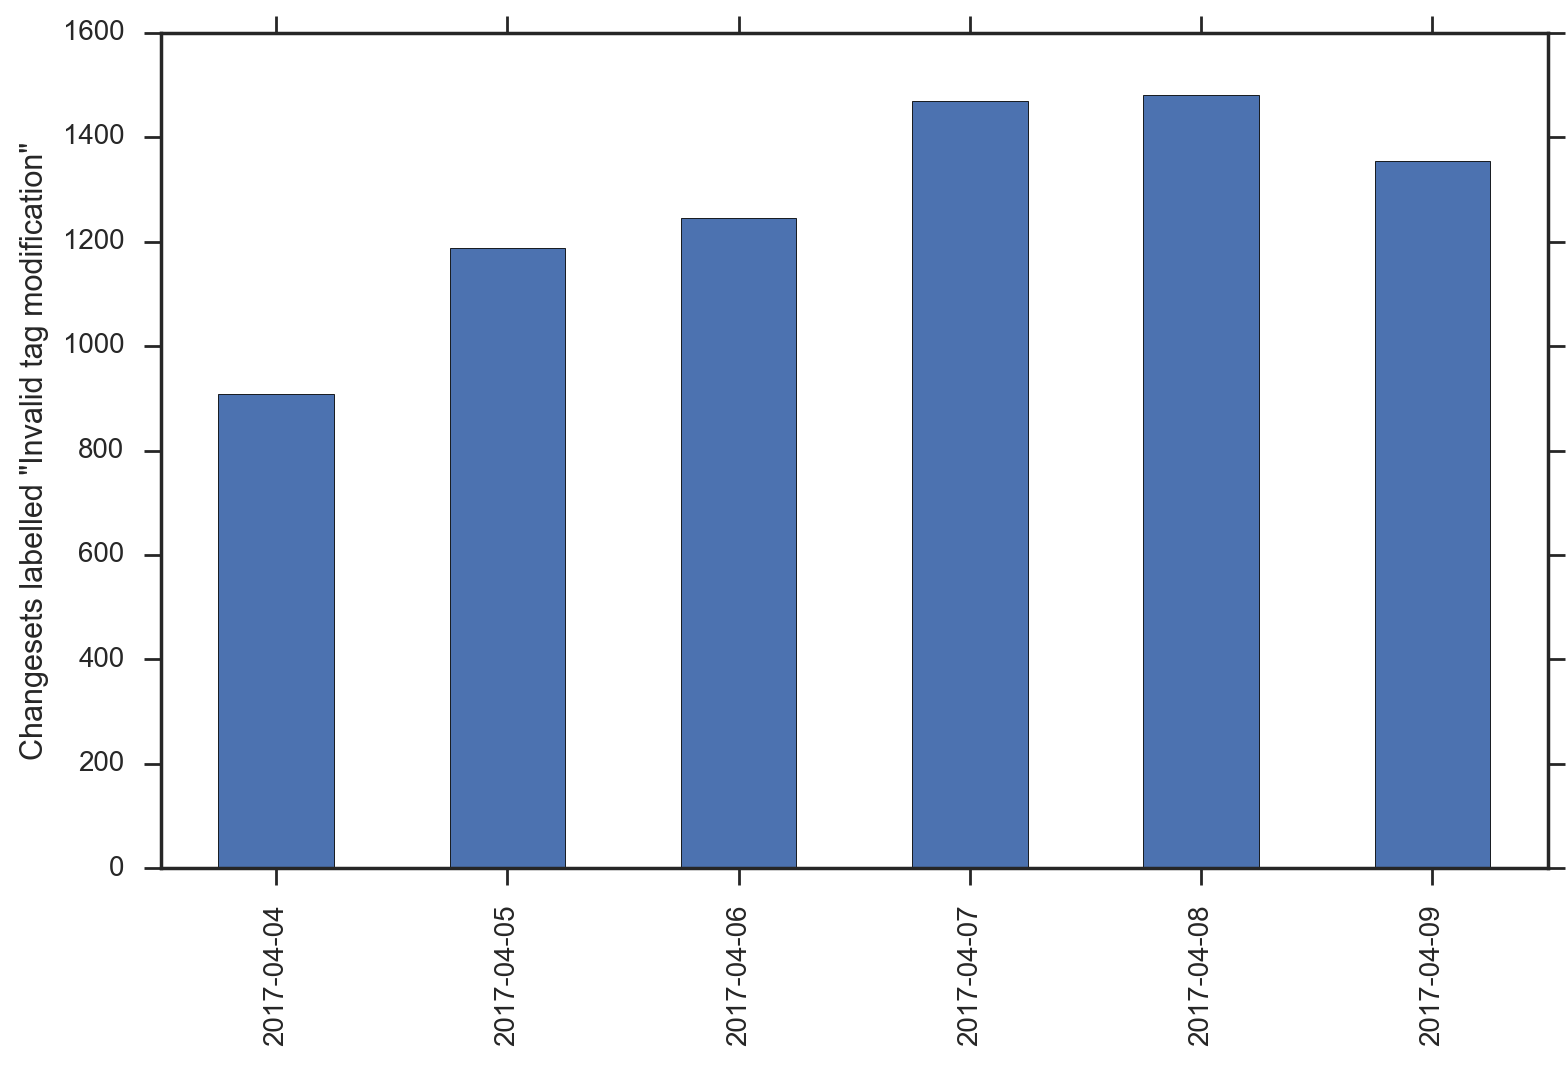

In [9]:
daily_counts = changesets.groupby(pd.Grouper(key='date', freq='1d'))['ID'].count()
ax = daily_counts.plot.bar()
ax.set_xlabel('')
ax.set_xticklabels([str(item) for item in daily_counts.keys().date]);
ax.set_ylabel('Changesets labelled "Invalid tag modification"')
plt.tight_layout()

## Different kinds of modifications

In [10]:
modifications = pd.read_csv('invalid-tag-modifications-v2.csv')
print(modifications.shape)
modifications.head(5)

(1892, 5)


,changeset_id,harmful,feature_url,created,deleted
0,47622129,True,http://osmcha.mapbox.com/47622129/features/way-478636519/,building,landuse
1,47614882,False,http://osmcha.mapbox.com/47614882/features/way-479406193/,NaN,building
2,47611562,False,http://osmcha.mapbox.com/47611562/features/node-358792677/,historic,amenity
3,47610141,True,http://osmcha.mapbox.com/47610141/features/node-4551592489/,tourism,amenity
4,47609653,False,http://osmcha.mapbox.com/47609653/features/way-485761848/,NaN,building


In [11]:
def get_feature_type(feature_url):
    if 'relation' in feature_url: return 'relation'
    elif 'node' in feature_url: return 'node'
    elif 'way' in feature_url: return 'way'

modifications['feature_type'] = modifications['feature_url'].apply(get_feature_type)
modifications.head(3)

,changeset_id,harmful,feature_url,created,deleted,feature_type
0,47622129,True,http://osmcha.mapbox.com/47622129/features/way-478636519/,building,landuse,way
1,47614882,False,http://osmcha.mapbox.com/47614882/features/way-479406193/,NaN,building,way
2,47611562,False,http://osmcha.mapbox.com/47611562/features/node-358792677/,historic,amenity,node


deleted
building            879
natural             379
landuse             230
amenity             113
highway             104
leisure             81 
waterway            34 
shop                15 
sport               15 
boundary            14 
tourism             7  
office              5  
public_transport    5  
aeroway             5  
historic            1  
railway             1  
emergency           1  
Name: feature_url, dtype: int64

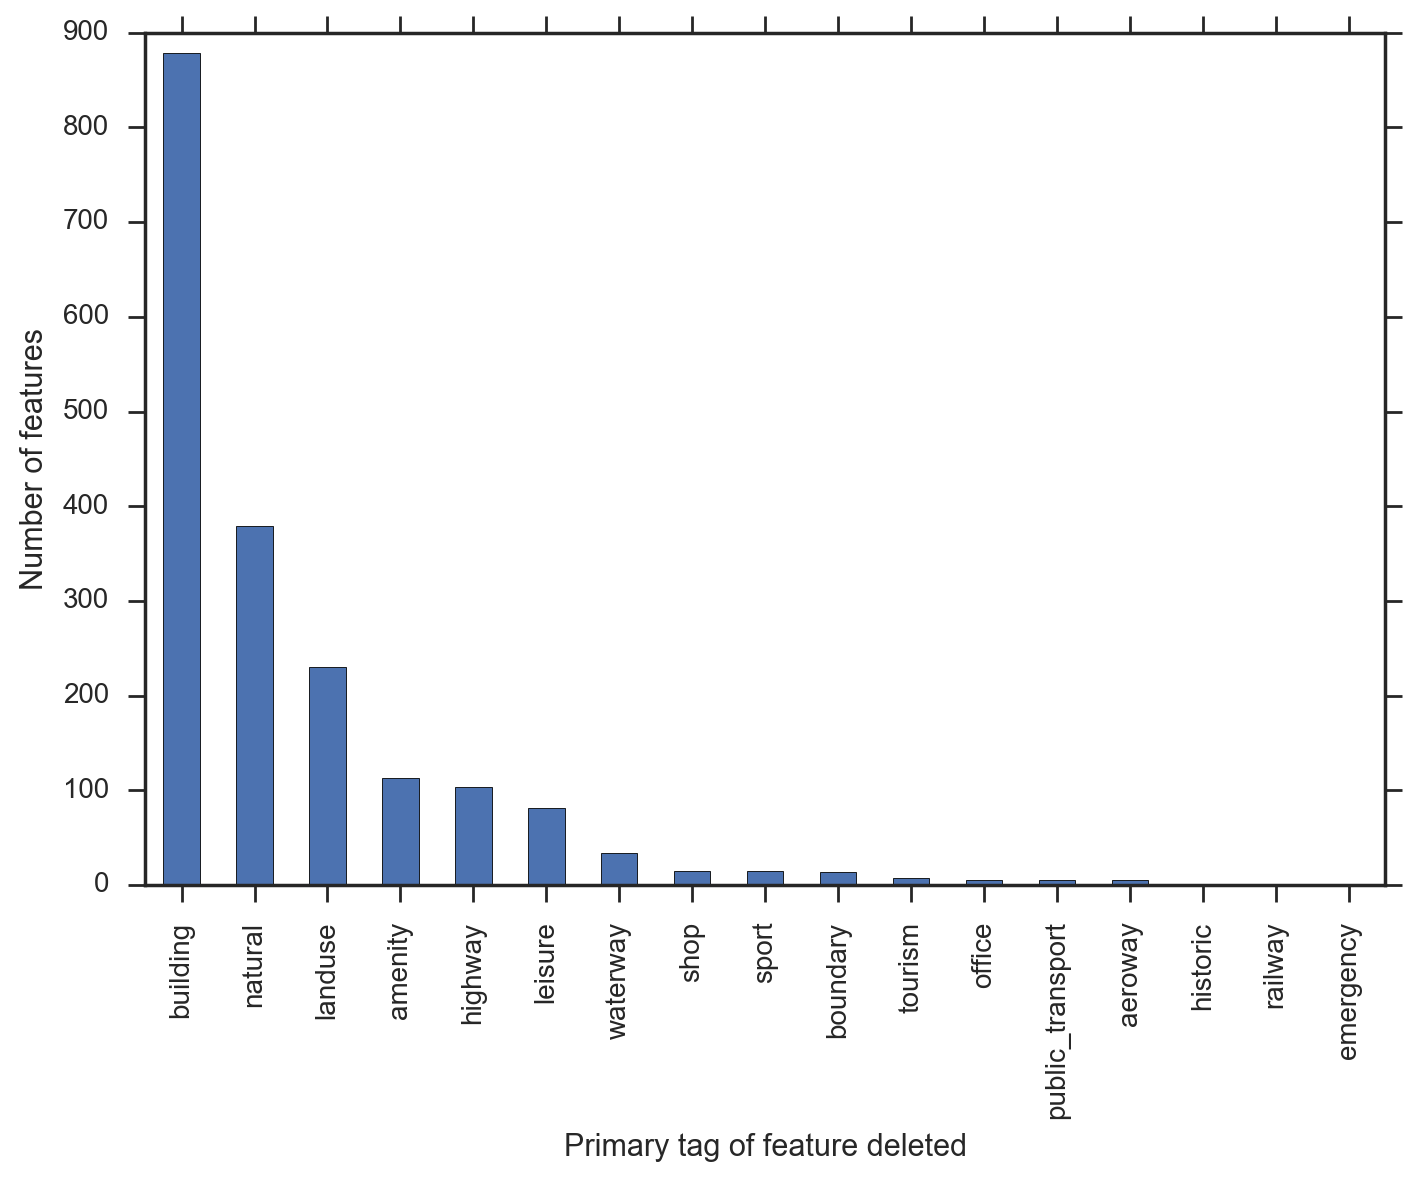

In [12]:
modification_counts = modifications.groupby('deleted')['feature_url'].count()
modification_counts.sort(ascending=False)

ax = modification_counts.plot.bar()
ax.set_xlabel('Primary tag of feature deleted')
ax.set_ylabel('Number of features')

modification_counts

### How does this vary for just the harmful changesets?

deleted
landuse     9
building    6
amenity     5
natural     4
office      3
leisure     3
highway     2
waterway    1
tourism     1
Name: feature_url, dtype: int64

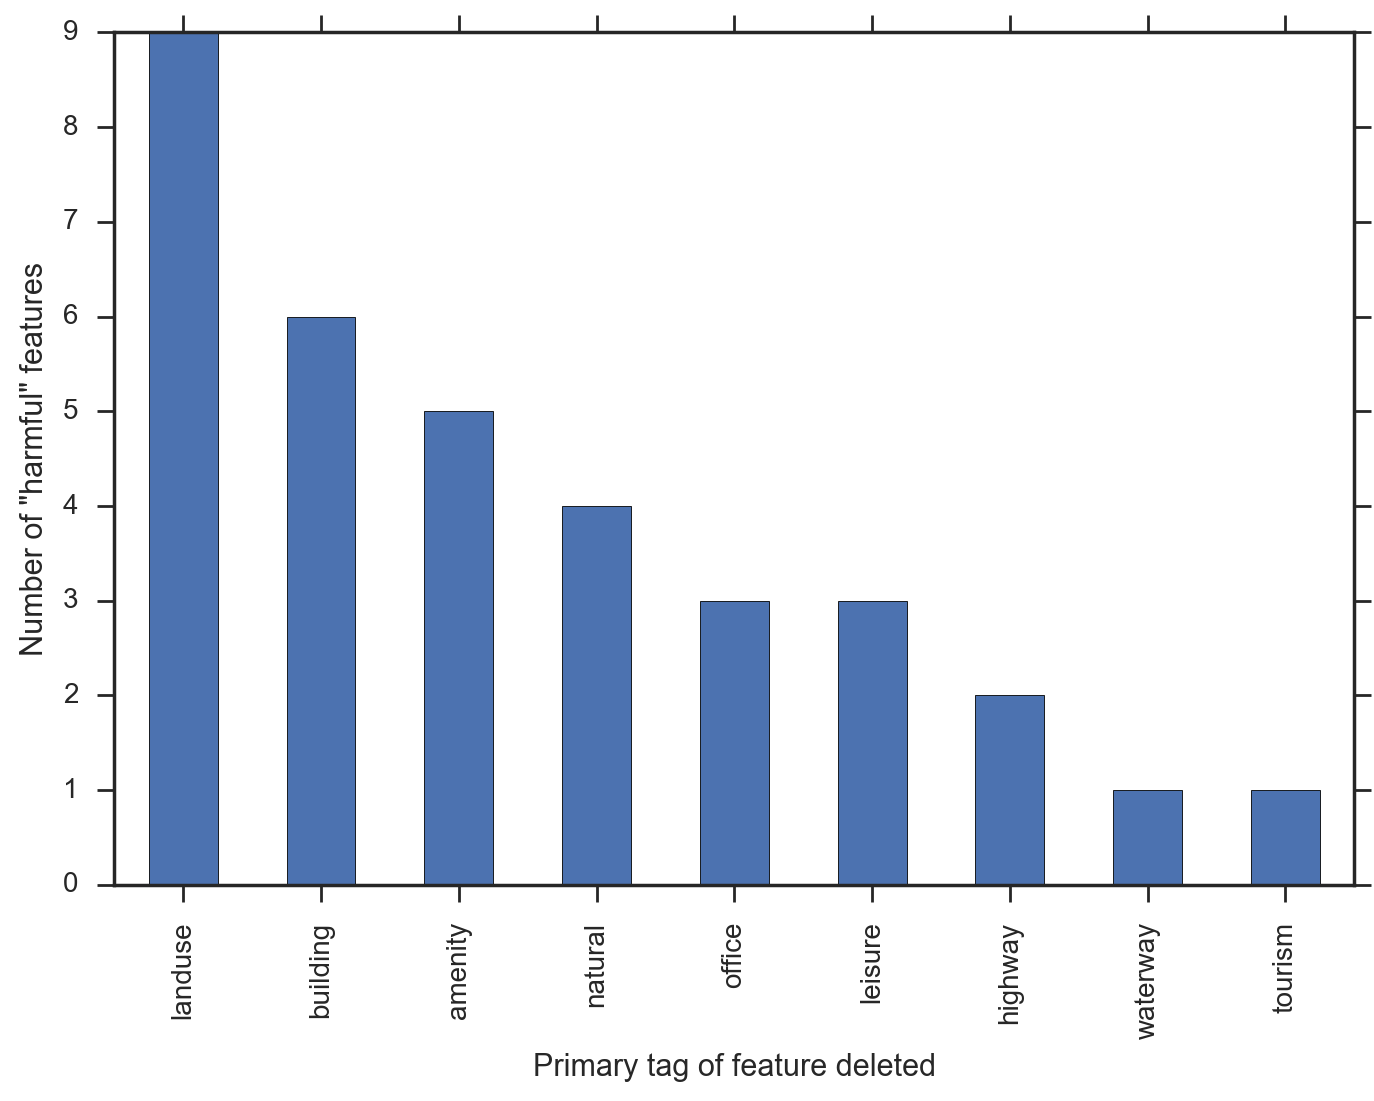

In [13]:
harmful_modification_counts = modifications[modifications['harmful'] == True].groupby('deleted')['feature_url'].count()
harmful_modification_counts.sort(ascending=False)

ax = harmful_modification_counts.plot.bar()
ax.set_xlabel('Primary tag of feature deleted')
ax.set_ylabel('Number of "harmful" features')

harmful_modification_counts

## Combining primary tag deleted and created

In [14]:
modifications.groupby(['deleted', 'created'])['feature_url'].count().unstack().fillna('')

created,amenity,building,highway,historic,landuse,leisure,man_made,natural,office,power,public_transport,shop,sport,tourism,waterway
deleted,,,,,,,,,,,,,,,
amenity,,1,,3,,7,,,2,,1,5,1,1,
building,16,,,,13,4,,,,,,2,1,,
highway,,,,,2,2,,,,1,,,1,,
landuse,6,8,,,,15,1,2,,,,,,1,
leisure,1,,1,,2,,,,,,,,,,1
natural,,1,,,1,9,,,,,,,,,1
office,2,,,,,,,,,,,,,,
shop,3,,,,,,,,1,,,,,,
tourism,,1,,,,,,,,,,,,,


In [15]:
modifications[modifications['harmful'] == True].groupby(['deleted', 'created'])['feature_url'].count().unstack().fillna('')

created,amenity,building,landuse,leisure,office,tourism,waterway
deleted,,,,,,,
amenity,,,,3,1,1,
building,1,,1,3,,,
highway,,,2,,,,
landuse,1,4,,2,,,
leisure,1,,1,,,,1
natural,,1,,2,,,
office,2,,,,,,
tourism,,1,,,,,


### What do the outliers look like?

In [16]:
# Out of the 8 features, 4 are labelled to be harmful.
modifications[(modifications['deleted'] == 'landuse') & (modifications['created'] == 'building')].head()

,changeset_id,harmful,feature_url,created,deleted,feature_type
0,47622129,True,http://osmcha.mapbox.com/47622129/features/way-478636519/,building,landuse,way
574,47571450,True,http://osmcha.mapbox.com/47571450/features/way-237855321/,building,landuse,way
593,47556010,True,http://osmcha.mapbox.com/47556010/features/way-362351419/,building,landuse,way
597,47551986,True,http://osmcha.mapbox.com/47551986/features/way-388038174/,building,landuse,way
868,47521192,False,http://osmcha.mapbox.com/47521192/features/relation-4656986/,building,landuse,relation


In [17]:
# Out of the 7 features, 3 are labelled to be harmful.
modifications[(modifications['deleted'] == 'amenity') & (modifications['created'] == 'leisure')].head()

,changeset_id,harmful,feature_url,created,deleted,feature_type
22,47604730,True,http://osmcha.mapbox.com/47604730/features/way-183982670/,leisure,amenity,way
542,47589949,False,http://osmcha.mapbox.com/47589949/features/way-367582686/,leisure,amenity,way
547,47584359,True,http://osmcha.mapbox.com/47584359/features/node-357789647/,leisure,amenity,node
548,47584339,True,http://osmcha.mapbox.com/47584339/features/node-357789645/,leisure,amenity,node
563,47577607,False,http://osmcha.mapbox.com/47577607/features/relation-1874805/,leisure,amenity,relation


## What are the buildings becoming then?
- With `879` features, `building` are the most deleted primary tag of features.
- If `building` get's deleted, what do these features become next?

In [18]:
building_modifications = modifications[modifications['deleted'] == 'building']

print('Another primary tag was added: {}'.format(building_modifications[modifications['created'].isnull() == False].shape[0]))
print('Another primary tag was not added: {}'.format(building_modifications[modifications['created'].isnull() == True].shape[0]))

Another primary tag was added: 36
Another primary tag was not added: 843


In [19]:
building_deletions = building_modifications[modifications['created'].isnull() == True]
building_deletions_harmful = building_deletions[building_deletions['harmful'] == False]
building_deletions_harmful.head(5)

,changeset_id,harmful,feature_url,created,deleted,feature_type
1,47614882,False,http://osmcha.mapbox.com/47614882/features/way-479406193/,NaN,building,way
4,47609653,False,http://osmcha.mapbox.com/47609653/features/way-485761848/,NaN,building,way
7,47607994,False,http://osmcha.mapbox.com/47607994/features/way-259295888/,NaN,building,way
33,47593988,False,http://osmcha.mapbox.com/47593988/features/node-1943916496/,NaN,building,node
41,47592706,False,http://osmcha.mapbox.com/47592706/features/way-482872430/,NaN,building,way


In [20]:
building_counts = building_modifications.groupby('created')['feature_url'].count()
building_counts.sort(ascending=False)
building_counts

created
amenity    16
landuse    13
leisure    4 
shop       2 
sport      1 
Name: feature_url, dtype: int64

## What is the role of the feature type: `node|way|relation`?

feature_type
node        110 
relation    14  
way         1768
Name: feature_url, dtype: int64

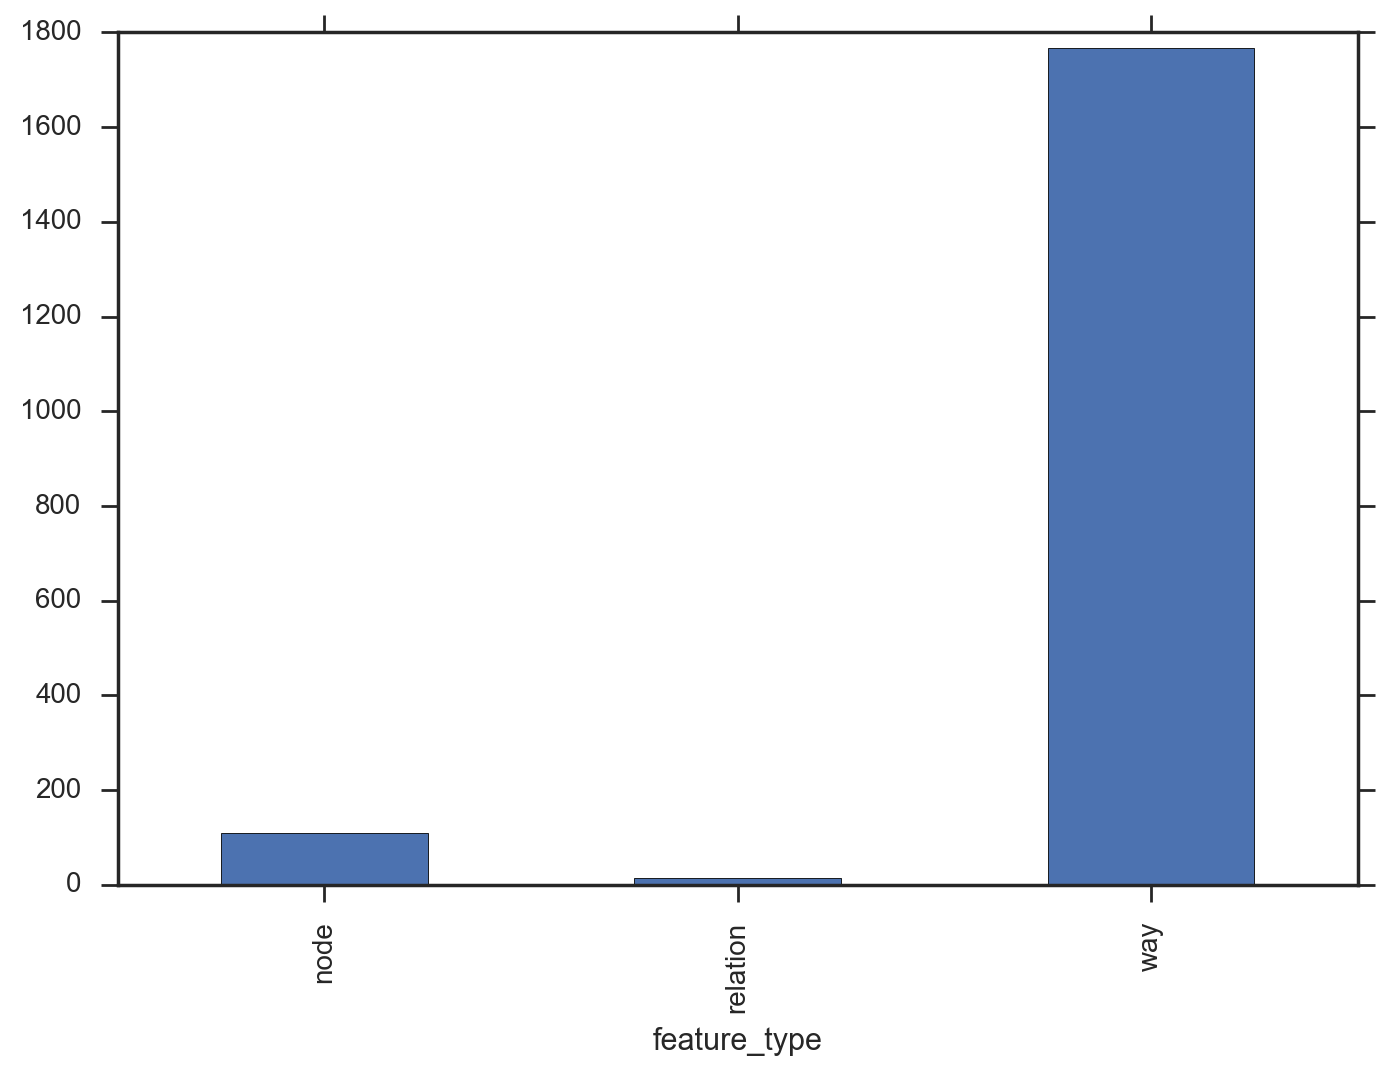

In [21]:
feature_type_counts = modifications.groupby('feature_type')['feature_url'].count()
feature_type_counts.plot.bar()
feature_type_counts

In [22]:
relation_modifications = modifications[modifications['feature_type'] == 'relation']
relation_modifications.head()

,changeset_id,harmful,feature_url,created,deleted,feature_type
30,47597674,False,http://osmcha.mapbox.com/47597674/features/relation-6259619/,NaN,amenity,relation
563,47577607,False,http://osmcha.mapbox.com/47577607/features/relation-1874805/,leisure,amenity,relation
572,47573485,False,http://osmcha.mapbox.com/47573485/features/relation-6873267/,NaN,landuse,relation
589,47562730,False,http://osmcha.mapbox.com/47562730/features/relation-4159316/,leisure,landuse,relation
591,47559978,False,http://osmcha.mapbox.com/47559978/features/relation-4098955/,NaN,natural,relation


## Similar to `building`, what are the `natural` becoming then?
- `379` features have `natural` removed.

In [23]:
natural_modifications = modifications[modifications['deleted'] == 'natural']
print('Another primary tag was added: {}'.format(natural_modifications[modifications['created'].isnull() == False].shape[0]))
print('Another primary tag was not added: {}'.format(natural_modifications[modifications['created'].isnull() == True].shape[0]))

Another primary tag was added: 12
Another primary tag was not added: 367


In [24]:
natural_deletions = natural_modifications[natural_modifications['created'].isnull() == True]
natural_deletions_harmful = natural_deletions[natural_deletions['harmful'] == False]
print(natural_deletions_harmful.shape)
natural_deletions_harmful.tail(5)

(366, 6)


,changeset_id,harmful,feature_url,created,deleted,feature_type
1552,47514902,False,http://osmcha.mapbox.com/47514902/features/way-4481547/,NaN,natural,way
1556,47514902,False,http://osmcha.mapbox.com/47514902/features/way-4378459/,NaN,natural,way
1564,47506174,False,http://osmcha.mapbox.com/47506174/features/way-254628730/,NaN,natural,way
1566,47503432,False,http://osmcha.mapbox.com/47503432/features/way-220061579/,NaN,natural,way
1570,47502590,False,http://osmcha.mapbox.com/47502590/features/way-207270861/,NaN,natural,way
